In [ ]:
import pandas as pd
import numpy as np
import gc
import time
import lightgbm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.linear_model import LogisticRegression,LinearRegression


In [2]:
sales = pd.read_csv('./data/sales_train.csv')
shops = pd.read_csv('./data/shops.csv')
items = pd.read_csv('./data/items.csv')
item_cats = pd.read_csv('./data/item_categories.csv')
test = pd.read_csv('./data/test.csv').set_index('ID')
submissions = pd.read_csv('./data/sample_submission.csv')

# sales = sales[sales['shop_id'].isin([25, 27, 30, 31])]
# test = test[test['shop_id'].isin([25, 27, 30, 31])]

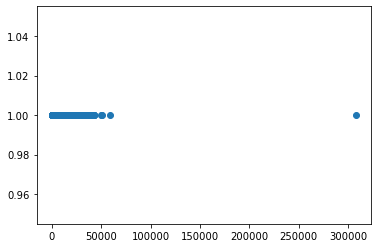

In [3]:
plt.scatter(x=sales['item_price'], y=np.ones(sales['item_price'].count()))   
plt.show()

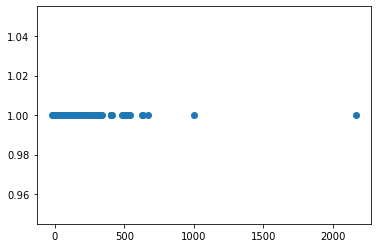

In [4]:
plt.scatter(x=sales['item_cnt_day'], y=np.ones(sales['item_price'].count()))   
plt.show()

In [5]:
sales = sales[sales['item_price'] < 40000]
sales = sales[sales['item_cnt_day'] < 400]
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)

In [6]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]

In [7]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items], [block_num])), dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns=index_cols)


In [8]:
test['date_block_num'] = 34
grid = pd.concat([grid, test], ignore_index=True, sort=False, keys=index_cols)
grid.fillna(0, inplace=True)
sales['revenue'] = sales['item_cnt_day']*sales['item_price']


In [9]:
# group by data to get shop-item-month aggregates
gb = sales.groupby(by=index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
gb['target'] = gb['target'].clip(0, 20)
# gb = gb.clip(0, 20)
data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [10]:
# group by data to get shop-month aggregates
gb = sales.groupby(by=['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)


In [11]:
# group by data to get item-month aggregates
gb = sales.groupby(by=['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


# group by data to get shop-item-month revenue
gb = sales.groupby(by=index_cols, as_index=False)['revenue'].sum()
gb = gb.rename(columns={'revenue': 'revenue_shop_item'})
data = pd.merge(data, gb, how='left', on=index_cols).fillna(0)


# group by data to get shop-month-revenue
gb = sales.groupby(by=['shop_id', 'date_block_num'], as_index=False)['revenue'].sum()
gb = gb.rename(columns={'revenue': 'revenue_shop'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# group by data to get item-month-revenue
gb = sales.groupby(by=['item_id', 'date_block_num'], as_index=False)['revenue'].sum()
gb = gb.rename(columns={'revenue': 'revenue_item'})
data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)



In [12]:
gb = sales.groupby(by=['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'item_avg_month'})
data = pd.merge(data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

gb = sales.groupby(by=['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'shop_avg_month'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

In [13]:
# data = pd.merge(sales, shops, on=['shop_id'], how='left')
# cats = pd.merge(sales, items[['item_id', 'item_category_id']], how='left', on=['item_id']).fillna(0)
data = pd.merge(data, items[['item_id', 'item_category_id']], how='left', on=['item_id']).fillna(0)
sales = pd.merge(sales, items[['item_id', 'item_category_id']], how='left', on=['item_id']).fillna(0)


In [14]:
gb = sales.groupby(by=['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'cat_item_avg'})
data = pd.merge(data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

In [15]:
data['month'] = data['date_block_num'] % 12 + 1
sales['month'] = sales['date_block_num'] % 12 + 1
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
data['days'] = data['month'].map(days)


In [16]:
gb = sales.groupby(by=['item_category_id', 'month'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'cat_item_month_avg'})
data = pd.merge(data, gb, how='left', on=['item_category_id', 'month']).fillna(0)

# gb = sales.groupby(by=['item_id', 'month'], as_index=False)['item_cnt_day'].mean()
# gb = gb.rename(columns={'item_cnt_day': 'item_month_avg'})
# data = pd.merge(data, gb, how='left', on=['item_id', 'month']).fillna(0)

gb = sales.groupby(by=['shop_id', 'month'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'shop_month_avg'})
data = pd.merge(data, gb, how='left', on=['shop_id', 'month']).fillna(0)

gb = sales.groupby(by=['item_category_id', 'shop_id', 'month'], as_index=False)['item_cnt_day'].mean()
gb = gb.rename(columns={'item_cnt_day': 'shop_cat_item_month_avg'})
data = pd.merge(data, gb, how='left', on=['item_category_id', 'shop_id', 'month']).fillna(0)

In [17]:
for column in data.columns:
    if data[column].dtype == 'int64':
        data[column] = data[column].astype('int32')
    if data[column].dtype == 'float64':
        data[column] = data[column].astype('float32')

In [18]:
ts = time.time()
cols_to_rename = ['target', 'target_shop', 'target_item', 'revenue_shop_item', 'revenue_shop', 
                  'revenue_item', 'cat_item_avg', 'item_avg_month', 'shop_avg_month',
                  'cat_item_month_avg', 'shop_month_avg', 'shop_cat_item_month_avg']
shift_range = [1, 2, 3, 6, 12]

for month_shift in shift_range:
    train_shift = data[index_cols+cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    train_shift = train_shift.rename(columns=(lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x))
    data = pd.merge(data, train_shift, on=index_cols, how='left').fillna(0)
print(time.time()-ts)


126.51974439620972


In [19]:
data = data.merge(shops, on=['shop_id'], how='left')

In [20]:
for column in data.columns:
    if data[column].dtype == 'int64':
        data[column] = data[column].astype('int32')
    if data[column].dtype == 'float64':
        data[column] = data[column].astype('float32')

In [19]:
# gb = sales.groupby(by=['shop_id', 'month'], as_index=False)['revenue'].sum()
# gb = gb.rename(columns={'revenue': 'shop_month_revenue'})
# data = pd.merge(data, gb, how='left', on=['shop_id', 'month']).fillna(0)

In [21]:
gb = sales.groupby(by=['item_id'], as_index=False)['date_block_num'].min()
gb = gb.rename(columns={'date_block_num': 'first_item_sale_date_block'})
data = pd.merge(data, gb, how='left', on=['item_id']).fillna(34)

In [22]:
to_drop_cols = ['date_block_num', 'target', 'target_shop', 'target_item', 
                'revenue_shop_item', 'revenue_item', 'revenue_shop',
                'item_avg_month', 'cat_item_avg', 'shop_avg_month',
                'cat_item_month_avg', 'shop_month_avg', 'shop_cat_item_month_avg']


In [23]:
dates = data['date_block_num']
last_block = dates.max()

In [24]:
dates_train = dates[dates < last_block]
dates_test = dates[dates == last_block]

x_train = data.loc[dates < last_block-1].drop(to_drop_cols, axis=1)
x_valid = data.loc[dates == last_block-1].drop(to_drop_cols, axis=1)
x_test = data.loc[dates == last_block].drop(to_drop_cols, axis=1)


y_train = data.loc[dates < last_block-1, 'target']
y_valid = data.loc[dates == last_block-1, 'target']



In [25]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10675438 entries, 0 to 10675437
Data columns (total 67 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   shop_id                         int32  
 1   item_id                         int32  
 2   item_category_id                int32  
 3   month                           int32  
 4   days                            float32
 5   target_lag_1                    float32
 6   target_shop_lag_1               float32
 7   target_item_lag_1               float32
 8   revenue_shop_item_lag_1         float32
 9   revenue_shop_lag_1              float32
 10  revenue_item_lag_1              float32
 11  cat_item_avg_lag_1              float32
 12  item_avg_month_lag_1            float32
 13  shop_avg_month_lag_1            float32
 14  cat_item_month_avg_lag_1        float32
 15  shop_month_avg_lag_1            float32
 16  shop_cat_item_month_avg_lag_1   float32
 17  target_lag_2             

In [26]:
ts = time.time()
x_train.to_csv('./data/created/x_train.csv', index=False)
y_train.to_csv('./data/created/y_train.csv', index=False)

x_valid.to_csv('./data/created/x_valid.csv', index=False)
y_valid.to_csv('./data/created/y_valid.csv', index=False)

x_test.to_csv('./data/created/x_test.csv', index=False)
del data
gc.collect()
print(time.time()-ts)


618.0791451931


In [2]:
x_train = pd.read_csv('./data/created/x_train.csv')
y_train = pd.read_csv('./data/created/y_train.csv')

x_valid = pd.read_csv('./data/created/x_valid.csv')
y_valid = pd.read_csv('./data/created/y_valid.csv')

x_test = pd.read_csv('./data/created/x_test.csv')

In [27]:
ts = time.time()
xgb = XGBRegressor(
    max_depth=8,
    n_estimators=250,
    min_child_weight=2**7,
    colsample_bytree=0.8,
    subsample=0.75,
    eta=0.2,
    # tree_method='hist',
    numthreads=8,
    # grow_police='lossguide',
    predictor='cpu_predictor',
    rate_drop=0.2
)
xgb.fit(x_train, y_train,
        eval_metric='rmse', eval_set=[(x_valid, y_valid)],
        verbose=True, early_stopping_rounds=10)
print(time.time()-ts)

[15:32:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.08837
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.04167
[2]	validation_0-rmse:1.00933
[3]	validation_0-rmse:0.98859
[4]	validation_0-rmse:0.97361
[5]	validation_0-rmse:0.96490
[6]	validation_0-rmse:0.95833
[7]	validation_0-rmse:0.95486
[8]	validation_0-rmse:0.95278
[9]	validation_0-rmse:0.94939
[10]	validation_0-rmse:0.94879
[11]	validation_0-rmse:0.94519
[12]	validation_0-rmse:0.94419
[13]	validation_0-rmse:0.94217
[14]	validation_0-rmse:0.94510
[15]	validation_0-rmse:0.94342
[16]	validation_0-rmse:0.94293
[17]	validation_0-rmse:0.94082
[18]	validation_0-rmse:0.94011
[19]	validation_0-rmse:0.94015
[20]	validation_0-rmse:0.93901
[21]	validation_0-rmse:0.93

In [26]:
x_train = pd.concat([x_train, x_valid], ignore_index=True, sort=False)
y_train = pd.concat([y_train, y_valid], ignore_index=True, sort=False)


In [8]:
ts = time.time()
xgb = XGBRegressor(
    max_depth=8,
    n_estimators=31,
    min_child_weight=2**7,
    colsample_bytree=0.8,
    subsample=0.75,
    eta=0.2,
    tree_method='hist',
    numthreads=8,
    grow_police='lossguide',
    predictor='cpu_predictor',
    rate_drop=0.2
)
xgb.fit(x_train, y_train)
print(time.time()-ts)

859.1808273792267


In [9]:
pred_xgb = xgb.predict(x_test).clip(0, 20)
valid_xgb = xgb.predict(x_valid).clip(0,20)

In [29]:
submissions = pd.DataFrame({
    'ID': x_test.index - x_test.index.min(),
    'item_cnt_month': pred_xgb
})
submissions.to_csv('submissions.csv', index=False)

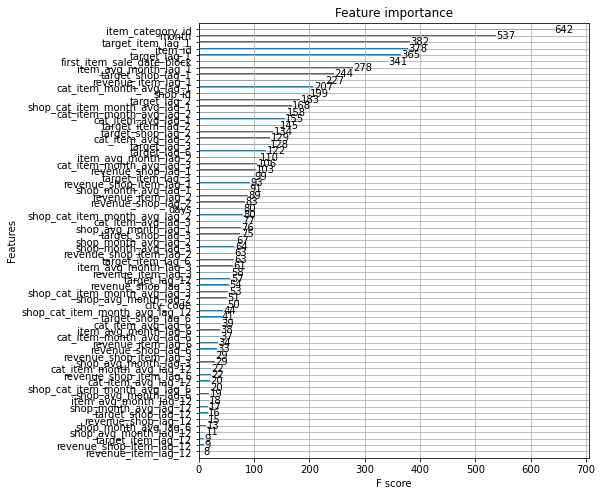

In [30]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


plot_features(xgb, (7, 8))
plt.show()


In [5]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'min_data_in_leaf': 2**7,
    'bagging_fraction': 0.75,
    'learning_rate': 0.1,
    'objective': 'mse',
    'bagging_seed': 2**7,
    'num_leaves': 2**8,
    'tree_learner': 'feature',
    'bagging_freq': 1,
    'verbose': 0,
    'n_jobs': 8,
}


In [6]:
lgbm = lightgbm.train(lgb_params, lightgbm.Dataset(x_train, label=y_train), num_boost_round=190,
                      valid_sets=lightgbm.Dataset(x_valid, label=y_valid), early_stopping_rounds=10)


[1]	valid_0's rmse: 1.09731
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 1.06901
[3]	valid_0's rmse: 1.04405
[4]	valid_0's rmse: 1.02475
[5]	valid_0's rmse: 1.00788
[6]	valid_0's rmse: 0.996273
[7]	valid_0's rmse: 0.984841
[8]	valid_0's rmse: 0.975717
[9]	valid_0's rmse: 0.967994
[10]	valid_0's rmse: 0.962812
[11]	valid_0's rmse: 0.957774
[12]	valid_0's rmse: 0.955848
[13]	valid_0's rmse: 0.954438
[14]	valid_0's rmse: 0.954072
[15]	valid_0's rmse: 0.951359
[16]	valid_0's rmse: 0.951615
[17]	valid_0's rmse: 0.951132
[18]	valid_0's rmse: 0.952676
[19]	valid_0's rmse: 0.952271
[20]	valid_0's rmse: 0.95178
[21]	valid_0's rmse: 0.952862
[22]	valid_0's rmse: 0.951104
[23]	valid_0's rmse: 0.951251
[24]	valid_0's rmse: 0.952483
[25]	valid_0's rmse: 0.951962
[26]	valid_0's rmse: 0.951366
[27]	valid_0's rmse: 0.950448
[28]	valid_0's rmse: 0.949838
[29]	valid_0's rmse: 0.951485
[30]	valid_0's rmse: 0.950939
[31]	valid_0's rmse: 0.95069
[32]	valid_0's rmse: 0.95

In [11]:
pred_lgb = lgbm.predict(x_test).clip(0, 20)
valid_lgbm = lgbm.predict(x_valid).clip(0, 20)

In [34]:
submissions = pd.DataFrame({
    'ID': x_test.index - x_test.index.min(),
    'item_cnt_month': pred_lgb
})

In [4]:
lr=LinearRegression()
lr.fit(x_train.values, y_train.values)
lr_preds = lr.predict(x_test.values).clip(0, 20)
valid_lr = lr.predict(x_valid).clip(0,20)

In [19]:
best_l = 0
best_lg = 0
best_x = 0
best_mse = 100

x_valid_2 = np.c_[valid_lr, valid_xgb, valid_lgbm]
x_test_level2 = np.c_[lr_preds, pred_xgb, pred_lgb]


In [17]:
print(mean_squared_error(y_valid, valid_lgbm, squared=False))
print(mean_squared_error(y_valid, valid_xgb, squared=False))
print(mean_squared_error(y_valid, valid_lr, squared=False))

0.9477952331363867
0.9332058595729492
0.9666766607879239


In [20]:
for l in np.arange(0, 1, 0.01):
    for x in np.arange(0, 1-l, 0.01):
        lg=1-x-l
        mix = l * x_valid_2[:, 0] + x * x_valid_2[:, 1] + lg * x_valid_2[:, 2]
        mse = mean_squared_error(y_valid, mix, squared=False)
        # print(mse)
        if mse < best_mse:
            best_mse = mse
            best_l = l
            best_lg = lg
            best_x = x
            print('mse={3}\n,linear={0}\nxgboost={1}\nlightgbm={2}\n'.format(best_l, best_x, best_lg, mse))


mse=0.9477952331363867
,linear=0.0
xgboost=0.0
lightgbm=1.0

mse=0.9472968735008263
,linear=0.0
xgboost=0.01
lightgbm=0.99

mse=0.94680539959979
,linear=0.0
xgboost=0.02
lightgbm=0.98

mse=0.9463208221616438
,linear=0.0
xgboost=0.03
lightgbm=0.97

mse=0.945843151786043
,linear=0.0
xgboost=0.04
lightgbm=0.96

mse=0.945372398942827
,linear=0.0
xgboost=0.05
lightgbm=0.95

mse=0.9449085739709268
,linear=0.0
xgboost=0.06
lightgbm=0.94

mse=0.9444516870772793
,linear=0.0
xgboost=0.07
lightgbm=0.9299999999999999

mse=0.9440017483357552
,linear=0.0
xgboost=0.08
lightgbm=0.92

mse=0.9435587676860939
,linear=0.0
xgboost=0.09
lightgbm=0.91

mse=0.9431227549328517
,linear=0.0
xgboost=0.1
lightgbm=0.9

mse=0.9426937197443601
,linear=0.0
xgboost=0.11
lightgbm=0.89

mse=0.9422716716516946
,linear=0.0
xgboost=0.12
lightgbm=0.88

mse=0.9418566200476556
,linear=0.0
xgboost=0.13
lightgbm=0.87

mse=0.9414485741857614
,linear=0.0
xgboost=0.14
lightgbm=0.86

mse=0.9410475431792522
,linear=0.0
xgboost=0.15
l

mse=0.9277626613784611
,linear=0.06
xgboost=0.54
lightgbm=0.39999999999999997

mse=0.9276949295473839
,linear=0.06
xgboost=0.55
lightgbm=0.38999999999999996

mse=0.9276344885493965
,linear=0.06
xgboost=0.56
lightgbm=0.37999999999999995

mse=0.9275813398097063
,linear=0.06
xgboost=0.5700000000000001
lightgbm=0.36999999999999994

mse=0.9275354845818748
,linear=0.06
xgboost=0.58
lightgbm=0.36000000000000004

mse=0.9274969239476708
,linear=0.06
xgboost=0.59
lightgbm=0.35000000000000003

mse=0.9274656588169419
,linear=0.06
xgboost=0.6
lightgbm=0.34

mse=0.9274416899275072
,linear=0.06
xgboost=0.61
lightgbm=0.33

mse=0.9274250178450716
,linear=0.06
xgboost=0.62
lightgbm=0.32

mse=0.9274156429631575
,linear=0.06
xgboost=0.63
lightgbm=0.31

mse=0.9274135655030588
,linear=0.06
xgboost=0.64
lightgbm=0.3

mse=0.9273819736719962
,linear=0.07
xgboost=0.53
lightgbm=0.39999999999999997

mse=0.9273148097663239
,linear=0.07
xgboost=0.54
lightgbm=0.38999999999999996

mse=0.9272549397607084
,linear=0.07


mse=0.9241356954481825
,linear=0.18
xgboost=0.44
lightgbm=0.38000000000000006

mse=0.9240895192252971
,linear=0.18
xgboost=0.45
lightgbm=0.37000000000000005

mse=0.9240506647695679
,linear=0.18
xgboost=0.46
lightgbm=0.36000000000000004

mse=0.9240191330046225
,linear=0.18
xgboost=0.47000000000000003
lightgbm=0.35000000000000003

mse=0.9239949246801316
,linear=0.18
xgboost=0.48
lightgbm=0.34

mse=0.9239780403717204
,linear=0.18
xgboost=0.49
lightgbm=0.33

mse=0.9239684804808989
,linear=0.18
xgboost=0.5
lightgbm=0.32

mse=0.9239662452350151
,linear=0.18
xgboost=0.51
lightgbm=0.31

mse=0.9239484918539216
,linear=0.19
xgboost=0.43
lightgbm=0.38000000000000006

mse=0.9239029042058412
,linear=0.19
xgboost=0.44
lightgbm=0.37000000000000005

mse=0.9238646398576652
,linear=0.19
xgboost=0.45
lightgbm=0.36000000000000004

mse=0.9238336997193668
,linear=0.19
xgboost=0.46
lightgbm=0.35000000000000003

mse=0.9238100845268511
,linear=0.19
xgboost=0.47000000000000003
lightgbm=0.34

mse=0.9237937948418

In [21]:
test_preds = best_l*x_test_level2[:, 0] + best_x * x_test_level2[:, 1] + best_lg * x_test_level2[:, 2]

submissions_enseble = pd.DataFrame({
    'ID': range(len(test_preds)),
    'item_cnt_month': test_preds
})

submissions_enseble.to_csv('submission_ensemble.csv', index=False)